# MAP55672: Case Studies in HPC
## Case 1: Communication-Avoiding QR — Question 1
### Mingjiu Yang
### TSQR Factorisation (4-processor simulation in Python)

This notebook implements the Tall-Skinny QR (TSQR) factorisation of a tall, narrow matrix $A \in \mathbb{R}^{m \times n}$, $m \gg n$, distributed across **4 processors** (simulated via row sub-indexing).

---

### Algorithm Overview

**Level 0 — Local QR on each block:**
$$A_i = Q_i^{(0)} R_i^{(0)}, \quad i = 0, 1, 2, 3$$

**Level 1 — Pairwise reduction (stack and QR):**
$$\begin{bmatrix} R_0^{(0)} \\ R_1^{(0)} \end{bmatrix} = Q_{01}^{(1)} R_{01}^{(1)}, \qquad \begin{bmatrix} R_2^{(0)} \\ R_3^{(0)} \end{bmatrix} = Q_{23}^{(1)} R_{23}^{(1)}$$

**Level 2 — Final reduction:**
$$\begin{bmatrix} R_{01}^{(1)} \\ R_{23}^{(1)} \end{bmatrix} = Q^{(2)} R$$

The $R$ produced at Level 2 is the upper-triangular factor of the full QR decomposition of $A$.

In [7]:
import numpy as np
from numpy.linalg import qr, norm
import matplotlib.pyplot as plt
import time

np.random.seed(42)  # reproducibility

---
## Part 1: TSQR Implementation

In [8]:
def tsqr(A, num_procs=4, verbose=True):
    """
    Communication-Avoiding TSQR factorisation.
    Simulates distribution onto `num_procs` processors using row sub-indexing.

    Parameters
    ----------
    A         : ndarray, shape (m, n), m >= n, m divisible by num_procs
    num_procs : int, number of simulated processors (must be power of 2)
    verbose   : bool, print intermediate shapes and residuals

    Returns
    -------
    R_final : upper-triangular factor, shape (n, n)
    Qs      : dict of all Q factors at each level (for full Q reconstruction)
    """
    m, n = A.shape
    assert m % num_procs == 0, "m must be divisible by num_procs"
    assert m >= n, "Matrix must be tall (m >= n)"

    block_size = m // num_procs  # rows per processor

    # ----------------------------------------------------------------
    # Level 0: Local QR on each processor block
    # Each processor i owns rows [ i*block_size : (i+1)*block_size ]
    # ----------------------------------------------------------------
    if verbose:
        print("=" * 55)
        print(f"Input matrix A: {m} x {n}")
        print(f"Block size per processor: {block_size} x {n}")
        print("=" * 55)
        print("\n--- Level 0: Local QR on each block ---")

    Qs = {}          # store all Q factors
    R_current = []   # R factors produced at this level

    for i in range(num_procs):
        row_start = i * block_size
        row_end   = (i + 1) * block_size
        A_block   = A[row_start:row_end, :]          # sub-indexing: rows of proc i

        Q_i, R_i = qr(A_block)                      # local QR (numpy built-in)

        Qs[(0, i)] = Q_i
        R_current.append(R_i)                        # keep only R (n x n)

        if verbose:
            print(f"  Proc {i}: A[{row_start}:{row_end}, :] -> "
                  f"Q shape {Q_i.shape}, R shape {R_i.shape}")

    # ----------------------------------------------------------------
    # Reduction tree: log2(num_procs) levels
    # At each level, pairs of R matrices are stacked and QR'd
    # ----------------------------------------------------------------
    level     = 1
    step      = 1   # which processors communicate (stride doubles each level)
    active    = list(range(num_procs))  # active processor indices

    while len(R_current) > 1:
        if verbose:
            print(f"\n--- Level {level}: Reduction ({len(R_current)} -> "
                  f"{len(R_current)//2} R matrices) ---")

        R_next   = []
        new_active = []

        for j in range(0, len(R_current), 2):
            # Stack two adjacent R matrices: shape (2n x n)
            R_stacked = np.vstack([R_current[j], R_current[j + 1]])

            Q_j, R_j = qr(R_stacked)               # QR of stacked R's

            proc_id = active[j]                     # label by owning processor
            Qs[(level, proc_id)] = Q_j
            R_next.append(R_j)
            new_active.append(proc_id)

            if verbose:
                print(f"  Merge procs {active[j]},{active[j+1]}: "
                      f"stacked shape {R_stacked.shape} -> "
                      f"Q {Q_j.shape}, R {R_j.shape}")

        R_current = R_next
        active    = new_active
        level    += 1

    R_final = R_current[0]   # upper-triangular factor of A

    if verbose:
        print(f"\n==> Final R shape: {R_final.shape}")

    return R_final, Qs

---
## Part 2: Correctness Verification

We verify TSQR by checking two things:

1. **R matches reference**: compare the absolute values of R from TSQR vs `numpy.linalg.qr(A)` directly (signs may differ due to Householder convention)
2. **Residual** $\|A - Q_{\text{ref}} R_{\text{TSQR}}\|_F$: if R is correct, then $Q_{\text{ref}} = A R^{-1}$ should be orthogonal

In [9]:
def verify_tsqr(A, R_tsqr, verbose=True):
    """
    Verify TSQR result against numpy's full QR as ground truth.

    Checks:
      (a) |R_tsqr| ≈ |R_ref|  (element-wise, sign-invariant)
      (b) ||A - Q_ref R_tsqr||_F / ||A||_F  (relative residual)
      (c) ||I - Q^T Q||_F  (orthogonality of Q_ref = A R_tsqr^{-1})
    """
    m, n = A.shape

    # Reference QR from numpy
    Q_ref, R_ref = qr(A, mode='reduced')   # Q: m x n, R: n x n

    # (a) R comparison (sign-invariant)
    R_diff = np.abs(R_tsqr) - np.abs(R_ref)
    r_err  = norm(R_diff, 'fro') / norm(R_ref, 'fro')

    # (b) Residual: reconstruct Q from A and R_tsqr via least squares
    #     Q* = A R^{-1}  (since A = QR => Q = AR^{-1})
    #     Use numpy solve for numerical stability
    Q_tsqr = np.linalg.solve(R_tsqr.T, A.T).T  # A @ inv(R)
    residual = norm(A - Q_tsqr @ R_tsqr, 'fro') / norm(A, 'fro')

    # (c) Orthogonality of recovered Q
    orth_err = norm(Q_tsqr.T @ Q_tsqr - np.eye(n), 'fro')

    if verbose:
        print("\n=== Verification ===")
        print(f"  Relative |R| difference vs numpy QR : {r_err:.2e}")
        print(f"  Relative residual ||A - QR||/||A||  : {residual:.2e}")
        print(f"  Orthogonality error ||I - Q^TQ||    : {orth_err:.2e}")
        tol = 1e-10
        ok  = (r_err < tol) and (residual < tol) and (orth_err < tol)
        print(f"  PASS: {ok}")

    return r_err, residual, orth_err


# --- Run a small concrete example ---
m, n = 1200, 6    # tall-skinny: 1200 rows, 6 cols, 4 processors of 300 rows each
A    = np.random.randn(m, n)

R_tsqr, Qs = tsqr(A, num_procs=4, verbose=True)
verify_tsqr(A, R_tsqr, verbose=True)

Input matrix A: 1200 x 6
Block size per processor: 300 x 6

--- Level 0: Local QR on each block ---
  Proc 0: A[0:300, :] -> Q shape (300, 6), R shape (6, 6)
  Proc 1: A[300:600, :] -> Q shape (300, 6), R shape (6, 6)
  Proc 2: A[600:900, :] -> Q shape (300, 6), R shape (6, 6)
  Proc 3: A[900:1200, :] -> Q shape (300, 6), R shape (6, 6)

--- Level 1: Reduction (4 -> 2 R matrices) ---
  Merge procs 0,1: stacked shape (12, 6) -> Q (12, 6), R (6, 6)
  Merge procs 2,3: stacked shape (12, 6) -> Q (12, 6), R (6, 6)

--- Level 2: Reduction (2 -> 1 R matrices) ---
  Merge procs 0,2: stacked shape (12, 6) -> Q (12, 6), R (6, 6)

==> Final R shape: (6, 6)

=== Verification ===
  Relative |R| difference vs numpy QR : 1.47e-16
  Relative residual ||A - QR||/||A||  : 9.28e-17
  Orthogonality error ||I - Q^TQ||    : 9.77e-16
  PASS: True


(np.float64(1.4678694341805342e-16),
 np.float64(9.284552644974627e-17),
 np.float64(9.769178180964442e-16))

---
## Part 3: Step-by-Step Walkthrough on a Tiny Matrix

To make the linear algebra transparent, we trace through a $16 \times 2$ example by hand.

In [10]:
print("=" * 55)
print("Tiny example: A is 16 x 2, split into 4 blocks of 4 rows")
print("=" * 55)

A_tiny = np.random.randn(16, 2)

# Level 0: local QR on each block
blocks = [A_tiny[i*4:(i+1)*4, :] for i in range(4)]
R0 = []
for i, blk in enumerate(blocks):
    Q_i, R_i = qr(blk)
    R0.append(R_i)
    print(f"\nProc {i}: A_block =\n{np.round(blk,3)}")
    print(f"  R_{i} =\n{np.round(R_i,4)}")

# Level 1: merge (0,1) and (2,3)
print("\n--- Level 1 merge ---")
stacked_01 = np.vstack([R0[0], R0[1]])
stacked_23 = np.vstack([R0[2], R0[3]])
Q01, R01 = qr(stacked_01)
Q23, R23 = qr(stacked_23)
print(f"Stack [R0;R1] -> R_01 =\n{np.round(R01,4)}")
print(f"Stack [R2;R3] -> R_23 =\n{np.round(R23,4)}")

# Level 2: final merge
print("\n--- Level 2 merge (final) ---")
stacked_final = np.vstack([R01, R23])
Q_final, R_final = qr(stacked_final)
print(f"Stack [R01;R23] -> R_final =\n{np.round(R_final,4)}")

# Compare with numpy reference
_, R_ref = qr(A_tiny, mode='reduced')
print(f"\nnumpy reference R =\n{np.round(R_ref,4)}")
print(f"\n|R_final| vs |R_ref| difference: {norm(np.abs(R_final)-np.abs(R_ref)):.2e}")

Tiny example: A is 16 x 2, split into 4 blocks of 4 rows

Proc 0: A_block =
[[ 0.14   0.065]
 [ 0.813 -0.844]
 [-1.744  0.157]
 [ 0.281  1.49 ]]
  R_0 =
[[-1.9495  0.2728]
 [ 0.      1.6987]]

Proc 1: A_block =
[[-1.27   1.155]
 [ 2.367 -0.378]
 [-1.291 -0.407]
 [ 0.014  0.564]]
  R_1 =
[[ 2.9808 -0.6132]
 [ 0.     -1.2584]]

Proc 2: A_block =
[[-0.591  1.555]
 [-1.115 -1.739]
 [ 1.107 -2.275]
 [-0.204  3.118]]
  R_2 =
[[ 1.6907 -1.2629]
 [ 0.      4.3293]]

Proc 3: A_block =
[[-0.012 -1.121]
 [-0.057 -0.051]
 [ 0.161  0.662]
 [-1.039  1.688]]
  R_3 =
[[ 1.0531 -1.5485]
 [ 0.      1.4653]]

--- Level 1 merge ---
Stack [R0;R1] -> R_01 =
[[ 3.5617 -0.6625]
 [ 0.     -2.1167]]
Stack [R2;R3] -> R_23 =
[[-1.9918  1.8906]
 [ 0.     -4.616 ]]

--- Level 2 merge (final) ---
Stack [R01;R23] -> R_final =
[[-4.0808  1.5011]
 [ 0.      5.2487]]

numpy reference R =
[[-4.0808  1.5011]
 [ 0.      5.2487]]

|R_final| vs |R_ref| difference: 9.93e-16


---
## Part 4: Scaling Experiments

We test how TSQR runtime scales with varying $m$ (fixed $n$) and varying $n$ (fixed $m$).

In [11]:
def benchmark_tsqr(m_vals, n_vals, repeats=5):
    """Benchmark TSQR over a grid of (m, n) values."""
    results = []
    for m in m_vals:
        for n in n_vals:
            if m < n or m % 4 != 0:
                continue
            times = []
            for _ in range(repeats):
                A = np.random.randn(m, n)
                t0 = time.perf_counter()
                tsqr(A, num_procs=4, verbose=False)
                times.append(time.perf_counter() - t0)
            results.append((m, n, np.mean(times)))
    return results

# --- Vary m, fixed n ---
n_fixed = 8
m_vals  = [400, 800, 1600, 3200, 6400, 12800, 25600]
res_m   = benchmark_tsqr(m_vals, [n_fixed])

# --- Vary n, fixed m ---
m_fixed = 4000
n_vals  = [2, 4, 8, 16, 32, 64, 128]
res_n   = benchmark_tsqr([m_fixed], n_vals)

print("Benchmarks done.")

Benchmarks done.


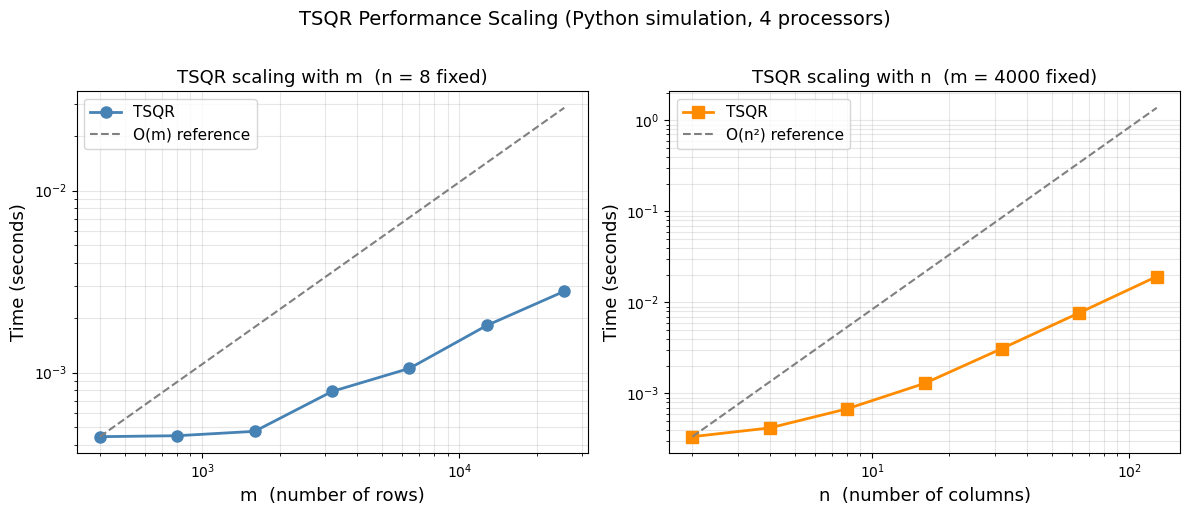

Scaling plot saved as tsqr_scaling.png


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Scaling with m (fixed n) ---
ms    = [r[0] for r in res_m]
times = [r[2] for r in res_m]

axes[0].loglog(ms, times, 'o-', color='steelblue', linewidth=2, markersize=8, label='TSQR')
# Reference linear line O(m)
t0_ref = times[0] / ms[0]
axes[0].loglog(ms, [t0_ref * m for m in ms], '--', color='gray', label='O(m) reference')
axes[0].set_xlabel('m  (number of rows)', fontsize=13)
axes[0].set_ylabel('Time (seconds)', fontsize=13)
axes[0].set_title(f'TSQR scaling with m  (n = {n_fixed} fixed)', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, which='both', alpha=0.3)

# --- Plot 2: Scaling with n (fixed m) ---
ns    = [r[1] for r in res_n]
times2= [r[2] for r in res_n]

axes[1].loglog(ns, times2, 's-', color='darkorange', linewidth=2, markersize=8, label='TSQR')
# Reference O(n^2)
t0_ref2 = times2[0] / ns[0]**2
axes[1].loglog(ns, [t0_ref2 * n**2 for n in ns], '--', color='gray', label='O(n²) reference')
axes[1].set_xlabel('n  (number of columns)', fontsize=13)
axes[1].set_ylabel('Time (seconds)', fontsize=13)
axes[1].set_title(f'TSQR scaling with n  (m = {m_fixed} fixed)', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, which='both', alpha=0.3)

plt.suptitle('TSQR Performance Scaling (Python simulation, 4 processors)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('tsqr_scaling.png', dpi=150, bbox_inches='tight')
plt.show()
print("Scaling plot saved as tsqr_scaling.png")